#                        - Computational Neuroscience 2021-2022 Final Project -        

##   Project Name: Combinatorial Codes in Ventral Temporal Lobe for Visual Object Recognition



The functional architecture of the object vision pathway in the human brain was
investigated using functional magnetic resonance imaging to measure patterns
of response in ventral temporal cortex while subjects viewed faces, cats, Þve
categories of man-made objects, and nonsense pictures. A distinct pattern of
response was found for each stimulus category. The distinctiveness of the
response to a given category was not due simply to the regions that responded
maximally to that category, because the category being viewed also could be
identiÞed on the basis of the pattern of response when those regions were
excluded from the analysis. Patterns of response that discriminated among all
categories were found even within cortical regions that responded maximally
to only one category. These results indicate that the representations of faces
and objects in ventral temporal cortex are widely distributed and overlapping.

In [1]:
!pip install umap
!pip install pipreqs
!pip install nibabel
!pip install nilearn
!pip install -U kaleido


try:
    import sklearn
    print('Scikit-learn is available, version', sklearn.__version__)
    
except:
    !pip install scikit-learn
    
 
try:
    import seaborn
    print('Seaborn is available, version', seaborn.__version__)
    
except:
     !pip install seaborn


^C
Requirement already up-to-date: kaleido in d:\python\lib\site-packages (0.2.1)
Scikit-learn is available, version 0.23.1
Open-CV is available, version 4.5.1
Seaborn is available, version 0.11.0


In [7]:
from __future__ import print_function, division

# Basics:
import numpy as np,pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os, random, time, sys, copy, math, pickle

# interactive mode
plt.ion()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



# Extras:
from abc import abstractmethod
from typing import Callable, Iterable, List, Tuple

# Set true for Google Colab:
COLAB = False

if COLAB:
    # To access Google Drive:
    from google.colab import drive
    drive.mount("/content/gdrive")

    
# For neuroimaging:
from nibabel.testing import data_path
from nilearn import plotting as nplt
from nilearn.input_data import NiftiMasker
from nilearn import datasets
from nilearn import plotting
from nilearn.image import mean_img
from nilearn.image import index_img
import nibabel as nib
from nilearn import image



print("NumPy Version: ", np.__version__)


root_dir = r'C:\Users\Administrator\Desktop\VOR'
os.chdir(root_dir)
image_results_dir = os.path.join(root_dir, 'images')
results_dir = os.path.join(root_dir, 'results')

print('Working Directory: \n ', root_dir)

NumPy Version:  1.19.1
Working Directory: 
  C:\Users\Administrator\Desktop\VOR


In [8]:
from utils.timers import timeit
from utils.metrics import accuracy, confusion_matrix, visualize_confusion_matrix
from utils.savers import save, save_obj, load, load_obj
from utils.reproduce import random_seed
from dataset.fetch_data_matrix import fetch_from_haxby
from visualizer.plot2D import plot_2d
from visualizer.plot3D import plot_3d  

# $  \:\:\:\:\:\:\:$  fMRI Spatio Temporal Data and Visual Stimuli Category Loading

$\textbf{Experimental View of the Haxby (Faces and Objects in Ventral Temporal Cortex (fMRI)) Dataset:}$  This is a block-design fMRI dataset (Haxby) from a study on face and object representation in human ventral temporal cortex. It consists of 6 subjects with 12 runs per subject. In each run, the subjects passively viewed greyscale images of eight object categories, grouped in 24s blocks separated by rest periods. Each image was shown for 500ms and was followed by a 1500ms inter-stimulus interval. Full-brain fMRI data were recorded with a volume repetition time of 2.5s, thus, a stimulus block was covered by roughly 9 volumes.

---
$\textbf{Dataset Description:}$

1. anat.nii.gz

- High resolution anatomical image. For subject 6 there is no anatomical image available.

2.bold.nii.gz
    
- 4D fMRI timeseries image. (1452 volumes with 40 x 64 x 64 voxels, corresponding to a voxel size of 3.5 x 3.75 x 3.75 mm and a volume repetition time of 2.5 seconds). The timeseries contains all 12 runs of the original experiment, concatenated in a single file. Please note, that the timeseries signal is not detrended.

3.mask*.nii.gz

- Various masks in functional space provided by the original authors. “vt” refers to “ventral temporal”, “face” and “house” masks are GLM contrast based localizer maps.

4.labels.txt

- A two-column text file with the stimulation condition and the corresponding experimental run for each volume in the timeseries image. Labels are given in literal form (e.g. ‘face’).

---

We have 8 different stimuli categories that are :  $\textbf{scissors, face, cat, scrambledpix, bottle, chair, shoe, house}$. We'll work with haxby dataset that can be downloaded directly from the neuroimaging library Nilearn. There are 6 subjects in the experiment that will be downloaded seperately with their fMRI images and masks. These fMRI images are 4-D nifti images.

In [9]:
# There are 6 number of subjects in the experiment: 
haxby_dataset = datasets.fetch_haxby(subjects= [1,2,3,4,5,6])

In [10]:
haxby_dataset

{'anat': ['C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj1\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj2\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj3\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj4\\anat.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj5\\anat.nii.gz',
  None],
 'func': ['C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj1\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj2\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj3\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj4\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj5\\bold.nii.gz',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj6\\bold.nii.gz'],
 'session_target': ['C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj1\\labels.txt',
  'C:\\Users\\Administrator/nilearn_data\\haxby2001\\subj2\\labels.tx

In [11]:
num_subjects = 6

for subject in range(num_subjects):   

    # 'func' is a list of filenames: one for each subject
    fmri_filename = haxby_dataset.func[subject]

    # print basic information on the dataset
    print('First subject functional nifti images (4D) are at: %s' %
          fmri_filename)  # 4D data

First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj1\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj2\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj3\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj4\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj5\bold.nii.gz
First subject functional nifti images (4D) are at: C:\Users\Administrator/nilearn_data\haxby2001\subj6\bold.nii.gz


# Explanatory Visual Stimuli Analysis

## Echo-planar imaging (EPI) Averaging for 4-D Visualization of the fMRI Nifti Image

In [ ]:
%%time

explanatory_fMRI_dir = os.path.join(image_results_dir, 'explanatory')

# cut in x-direction
sagittal = -25
# cut in y-direction
coronal = -37
# cut in z-direction
axial = -6

# coordinates displaying should be prepared as a list
cut_coords = [sagittal, coronal, axial]


# Echo-planar imaging (EPI) Averaged for 4-D
epi_image = mean_img(fmri_filename)

plotting.view_img(epi_image,
                  threshold=None,
                  title = 'fMRI Volume',
                  #output_file = os.path.join(explanatory_fMRI_dir + 'fMRI_volume.png'),
                  )

## A mask of the Ventral Temporal (VT) cortex with egion of Interest (RoI) 

In [14]:
def RoI_visualizer(haxby_dataset = haxby_dataset, subject_id:int = random.randint(0,5)) -> None:
    """
        Given the subject id from i = 1,...,6, visualize the a mask of the Ventral Temporal (VT) cortex,
        coming from the Haxby with the Region of Interest (RoI) 
        
        Arguments:
        
            subject_id (int) = Subject number 
            
        Returns:
            - None  
    """
    
    # Subject ID from i = 0,...,5:
    # subject_id = 3

    # Get mask filename:
    mask_filename = haxby_dataset.mask_vt[subject_id]


    # Region of Interest Visualizations:
    plotting.plot_roi(mask_filename,
                      bg_img=haxby_dataset.anat[subject_id],
                      cmap='Paired',
                      title = f'Region of Interest of subject {subject_id}',
                      figure= plt.figure(figsize=(12,4)),
                      alpha=0.7,
                      #output_file = os.path.join(explanatory_fMRI_dir, 'roi.png'
                      )

    plotting.show()

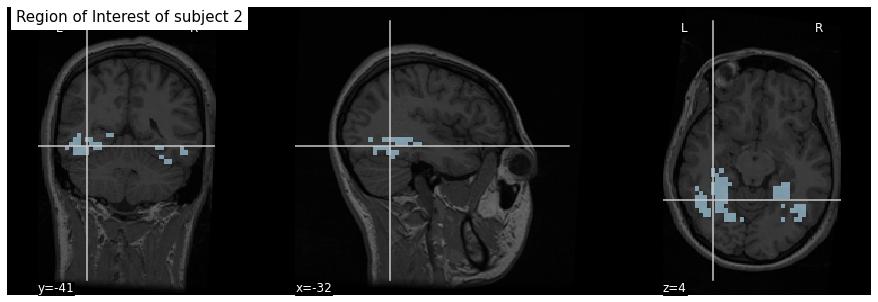

In [15]:
RoI_visualizer(subject_id=2)

## Statistical Maps

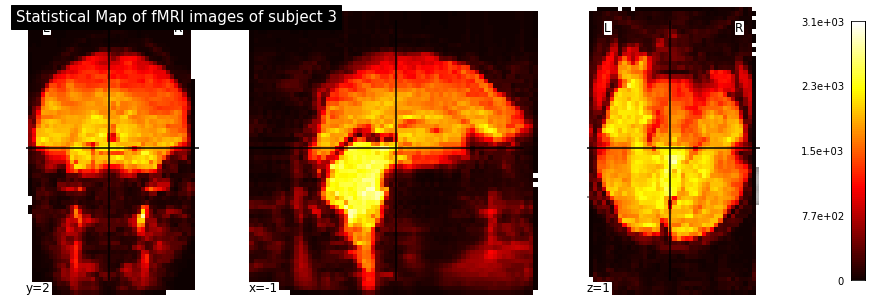

In [16]:
subject_id =  3

plotting.plot_stat_map(mean_img(fmri_filename),
                       threshold=3,
                       figure=plt.figure(figsize=(12,4)),
                       title=f'Statistical Map of fMRI images of subject {subject_id}',
                       #output_file = os.path.join(explanatory_fMRI_dir, 'stats_map.png')
                       )
plt.show()

## Simple, Compact, fMRI Visualizations 

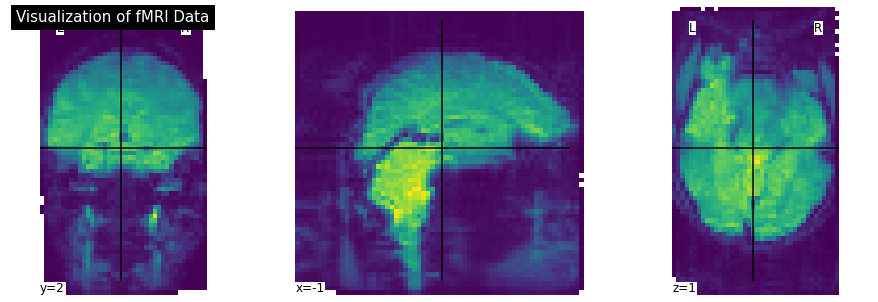

In [17]:
plotting.plot_img(mean_img(fmri_filename),
                 cut_coords=None,
                 #output_file= os.path.join(explanatory_fMRI_dir, 'fMRI.png'),
                 display_mode='ortho',
                 figure=plt.figure(figsize = (12,4)),
                 axes=None,
                 title='Visualization of fMRI Data',
                 threshold=3,
                 annotate=True,
                 draw_cross=True,
                 black_bg=False,
                 colorbar=False)
plt.show()

## EPI Plotting 

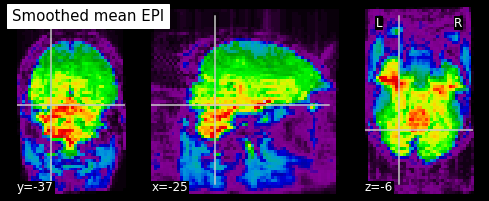

In [18]:
plotting.plot_epi(mean_img(fmri_filename),
                  title='Smoothed mean EPI',
                  cut_coords=cut_coords,
                  #output_file= os.path.join(explanatory_fMRI_dir, 'epi.png')
                 )

## Anatomic fMRI Visualizations

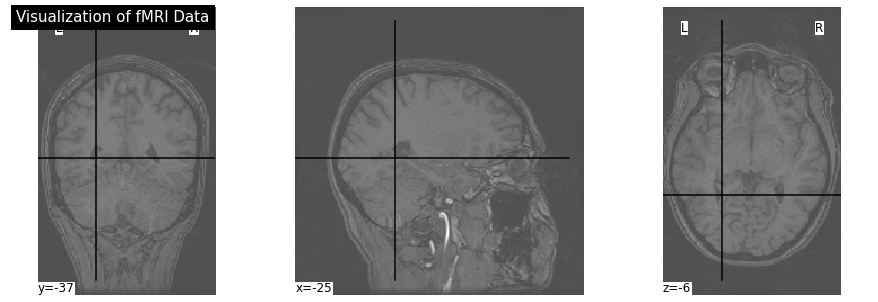

In [19]:
plotting.plot_anat(haxby_dataset.anat[0],
                  cut_coords=cut_coords,
                  #output_file= os.path.join(explanatory_fMRI_dir, 'anat.png'),
                  display_mode='ortho',
                  figure=plt.figure(figsize = (12,4)),
                  axes=None,
                 title='Visualization of fMRI Data',
                 threshold=None,
                 annotate=True,
                 draw_cross=True,
                 black_bg=False,
                 colorbar=False)
plotting.show()

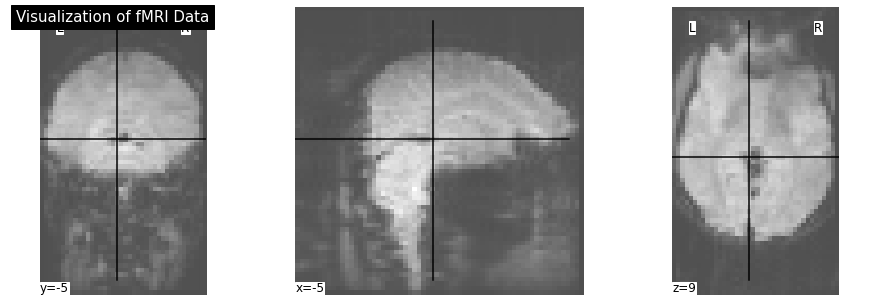

In [20]:
plotting.plot_anat(mean_img(fmri_filename),
                  cut_coords=None,
                  output_file=None,
                  display_mode='ortho',
                  figure=plt.figure(figsize = (12,4)),
                  axes=None,
                  title='Visualization of fMRI Data',
                  threshold=None,
                  annotate=True,
                  draw_cross=True,
                  black_bg=False,
                  colorbar=False)
plotting.show()

## Plot Haxby masks 

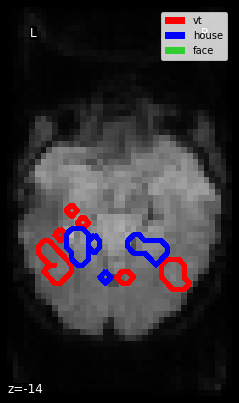

In [21]:
# Build the mean image because we have no anatomic data


func_filename = haxby_dataset.func[0]
_mean_img = image.mean_img(func_filename)

z_slice = -14

fig = plt.figure(figsize=(4, 5.4), facecolor='k')

from nilearn.plotting import plot_anat, show

display = plot_anat(_mean_img, display_mode='z', cut_coords=[z_slice],
                    figure=fig)

mask_vt_filename = haxby_dataset.mask_vt[0]
mask_house_filename = haxby_dataset.mask_house[0]
mask_face_filename = haxby_dataset.mask_face[0]

display.add_contours(mask_vt_filename,
                     contours=1,
                     antialiased=False,
                     linewidths=4.,
                     levels=[0],
                     colors=['red'])
display.add_contours(mask_house_filename,
                     contours=1,
                     antialiased=False,
                     linewidths=4.,
                     levels=[0],
                     colors=['blue'])
display.add_contours(mask_face_filename,
                     contours=1,
                     antialiased=False,
                     linewidths=4.,
                     levels=[0],
                     colors=['limegreen'])

# We generate a legend using the trick described on
# http://matplotlib.sourceforge.net/users/legend_guide.httpml#using-proxy-artist
from matplotlib.patches import Rectangle
p_v = Rectangle((0, 0), 1, 1, fc="red")
p_h = Rectangle((0, 0), 1, 1, fc="blue")
p_f = Rectangle((0, 0), 1, 1, fc="limegreen")
plt.legend([p_v, p_h, p_f], ["vt", "house", "face"])

plt.show()



#display.savefig(os.path.join(explanatory_fMRI_dir, 'pretty_brain_response.png'))

## Glass Brain Plotting 

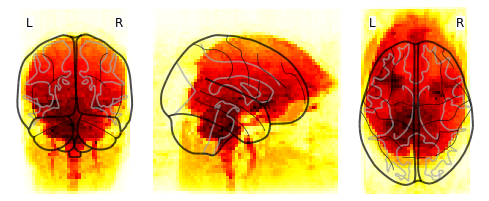

In [23]:
plotting.plot_glass_brain(mean_img(fmri_filename),
                          threshold=3,
                          #output_file= os.path.join(explanatory_fMRI_dir, 'glass_brain_white.png')
                          )
plotting.show()

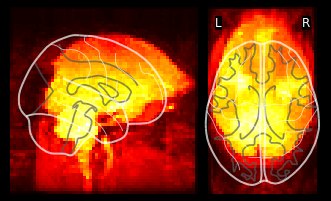

In [22]:
plotting.plot_glass_brain(
    mean_img(fmri_filename),
    black_bg=True,
    display_mode='xz',
    threshold=None,
    #output_file= os.path.join(explanatory_fMRI_dir, 'glass_brain_black.png')
   )

plotting.show()

## Stimuli Visualizations 

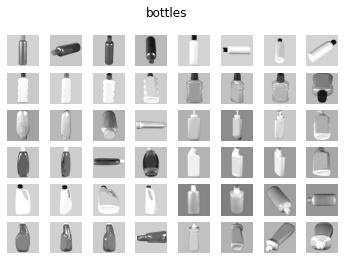

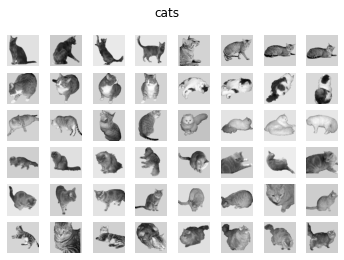

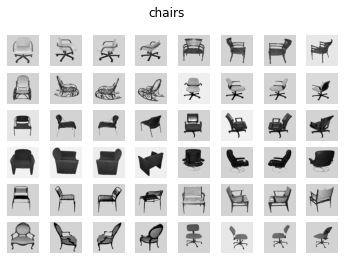

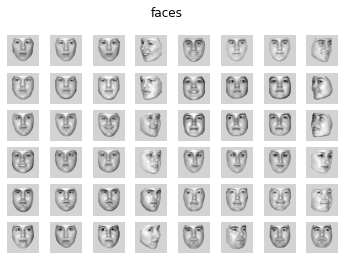

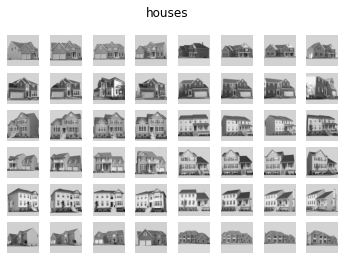

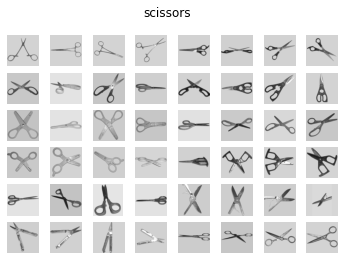

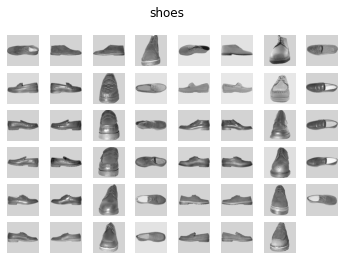

In [24]:
haxby_dataset_stimuli = datasets.fetch_haxby(subjects=[], fetch_stimuli=True)
stimulus_information = haxby_dataset_stimuli.stimuli

for stimulus_type in [*stimulus_information]:
    
    if stimulus_type != 'controls':

        img_paths = stimulus_information[stimulus_type]
        
        fig, axes = plt.subplots(6, 8)
        fig.suptitle(stimulus_type)

        for img_path, ax in zip(img_paths, axes.ravel()):
            image = plt.imread(img_path)
            ax.imshow(image, cmap='gray')

        for ax in axes.ravel():
            ax.axis("off")
            
            
        #fig.savefig(os.path.join(explanatory_fMRI_dir, f'{stimulus_type}.png')) 

plt.show()
    
    

# Interactive Brain Visualizations 

##  3D Plots of statistical maps on the cortical surface

In [ ]:
plotting.view_img_on_surf(mean_img(fmri_filename), threshold='90%', surf_mesh='fsaverage') 

In [ ]:
plotting.view_img_on_surf(mean_img(fmri_filename), threshold='70%', surf_mesh='fsaverage') 

## Brain Marking

In [ ]:
plotting.view_markers( 
[(0, -52, 18), (-46, -68, 32), (46, -68, 32), (1, 50, -5)],
['red', 'cyan', 'magenta', 'orange'],
marker_size=10) 